# Selecting the Center Mask
In this notebook we'll learn about how we can select the center most mask from a RGB image that multiple distinct colour-coded masks; see image:

<img src="data/Segments/3qq031609lA_00002/0001.png" alt="example masks" width="256"/>

Pixels that belong to the same masks have the same colour, so we should be able to select distinct masks by their colour.
Then the position can be determined of each mask, and we can therefore exclude all masks that do not have the majority of the mass in the center.

## Imports

In [213]:
import os
import av

import matplotlib.pyplot as plt
import numpy as np
import diveslowlearnfast as dlf

from PIL import Image

assert os.path.exists('data/Segments/iv0Gu1VXAgc_00167/0001.png')

## Loading the masks

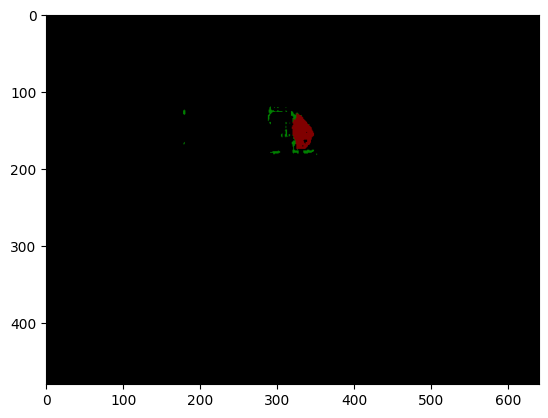

In [293]:
idx = 53
mask_path = f'data/Segments/aektxm8cLdo_00000/{idx:04d}.png'
mask_img = Image.open(mask_path)
plt.imshow(mask_img)

mask.shape: (480, 640)


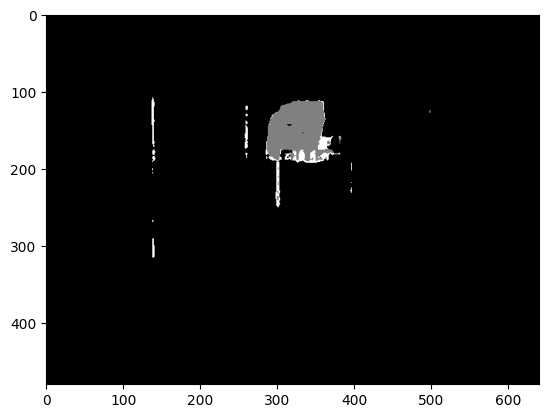

In [285]:
mask = np.array(mask_img)
print(f'mask.shape: {mask.shape}')
plt.imshow(mask, cmap='gray')

The mask is a gray scale image, so we can probably find several distinct floating point values

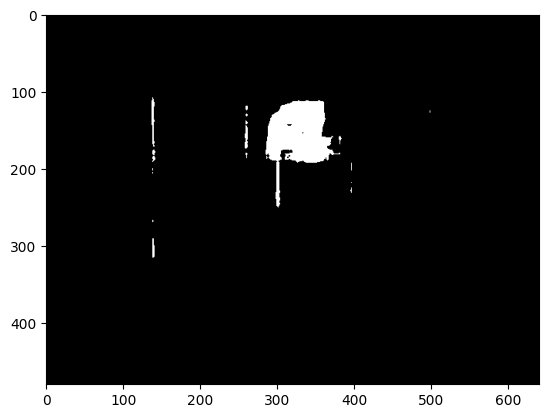

In [286]:
mask_indices = np.unique(mask)

plt.imshow(np.logical_or(mask == 1, mask == 2), cmap='gray')

mask_center.unique: [0 1 2]
masses: [95856  4702  1202]
masses: 3


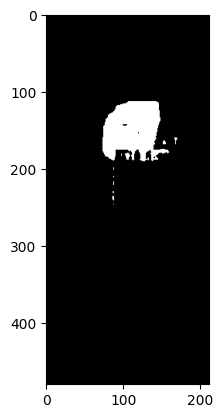

In [288]:
w = mask.shape[1]
size = w//6
mask_center = mask[:, w//2-size:w//2+size]
print(f'mask_center.unique: {np.unique(mask_center)}')
masses = np.bincount(mask_center.flatten())
print(f'masses: {masses}')
print(f'masses: {len(masses)}')
plt.imshow(mask_center == 1, cmap='gray')

Create a function that can find our diver. For now we just select the highest mass that is not the zero index, i.e. the background mask.

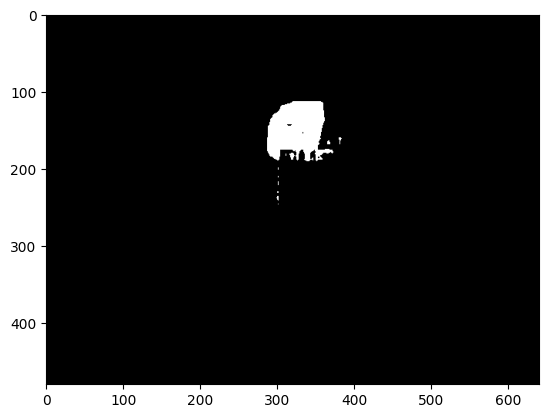

In [290]:
def find_diver_mask(mask):
    w = mask.shape[1]
    mw = w//6
    mask_center = mask[:, w//2-mw:w//2+mw]
    masses = np.bincount(mask_center.flatten())
    masses = masses[1:min(4, len(masses) - 1)]
    if len(masses) == 0:
        return np.zeros_like(mask)
    return mask == np.argmax(masses) + 1

diver_mask = find_diver_mask(mask)
plt.imshow(diver_mask, cmap='gray')

## Video Masks
Let's now turn our mask into a video and check for stability

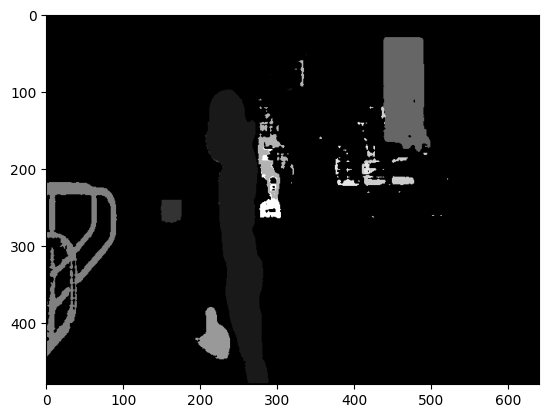

In [102]:
def load_masks(path):
    masks = []
    filenames = sorted(os.listdir(path))
    for filename in filenames:
        mask_path = f'{path}/{filename}'
        if not os.path.exists(mask_path):
            break
        mask_img = Image.open(mask_path)
        mask = np.array(mask_img)
        masks.append(mask)
    return masks

masks_path = 'data/3qq031609lA_00002'
masks = load_masks(masks_path)
plt.imshow(masks[6], cmap='gray')

masses: [16635     0    31  1278     0  1658  1613   443   535   739]
masses.argmax: 0


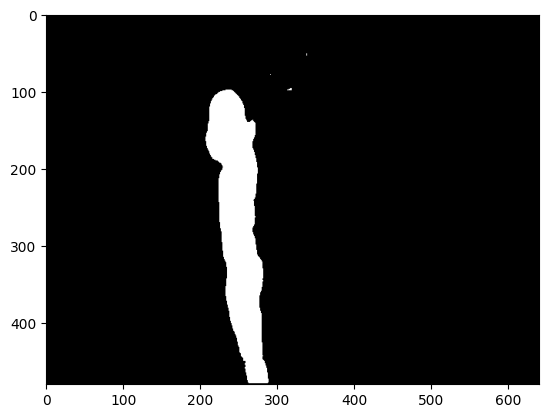

In [103]:
diver_mask = find_diver_mask(masks[6])
plt.imshow(diver_mask, cmap='gray')

masses: [17848 23998     0]
masses.argmax: 1
masses: [17552 23592     0]
masses.argmax: 1
masses: [17263 23438     0]
masses.argmax: 1
masses: [17102 23434     0]
masses.argmax: 1
masses: [17111 23106     0]
masses.argmax: 1
masses: [17052     0  1023]
masses.argmax: 0
masses: [16635     0    31]
masses.argmax: 0
masses: [16154     0   104]
masses.argmax: 0
masses: [15733     0  2590]
masses.argmax: 0
masses: [15697     0  2822]
masses.argmax: 0
masses: [14721   208     0]
masses.argmax: 0
masses: [15059    66     0]
masses.argmax: 0
masses: [14775 15006     0]
masses.argmax: 1
masses: [15544     0 17626]
masses.argmax: 2
masses: [14765     0 20411]
masses.argmax: 2
masses: [14772     0 20747]
masses.argmax: 2
masses: [12219     0     0]
masses.argmax: 0
masses: [13233 21002     0]
masses.argmax: 1
masses: [14784 20267     0]
masses.argmax: 1
masses: [15723     0 23564]
masses.argmax: 2
masses: [16614     0   634]
masses.argmax: 0
masses: [16602     0   634]
masses.argmax: 0
masses: [1

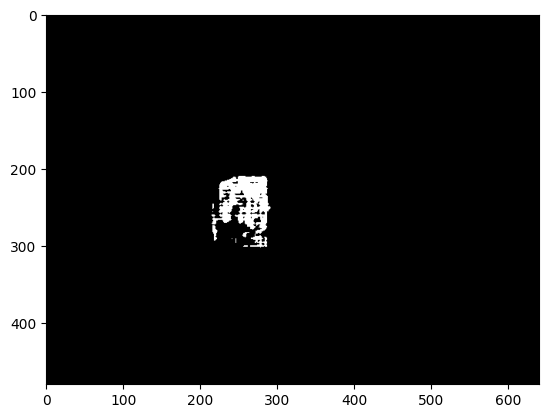

In [134]:
masks_diver = np.stack([find_diver_mask(mask) for mask in masks])

plt.imshow(masks_diver[100], cmap='gray')

## Create a Segmented Video of the diver

video.shape: (110, 480, 640, 3)


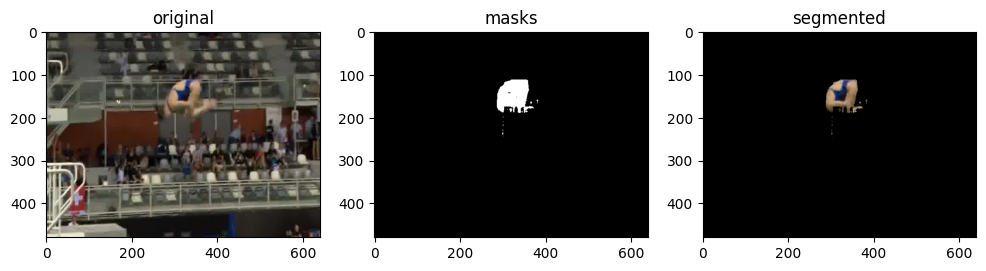

In [296]:
def load_video_mp4(path):
    frames = []
    container = av.open(path)
    for idx, frame in enumerate(container.decode(video=0)):
        frames.append(frame.to_ndarray(format='rgb24'))

    return np.stack(frames)

def load_video_jpeg(path):
    video = []
    filenames = sorted(os.listdir(path))
    for filename in filenames:
        image_path = f'{path}/{filename}'
        if not os.path.exists(image_path):
            break
        img = Image.open(image_path)
        video.append(np.array(img))
    return np.stack(video)

vidnames = ['3qq031609lA_00002', 'iv0Gu1VXAgc_00167', 'aektxm8cLdo_00000']
vidname = vidnames[2]
video = load_video_jpeg(f'data/JPEGImages/{vidname}')
masks = load_masks(f'data/Segments/{vidname}')
masks_diver = np.stack([find_diver_mask(mask) for mask in masks])
idx = 49
print(f'video.shape: {video.shape}')
plt.figure(figsize=(12, 4))

ax = plt.subplot(131)
ax.imshow(video[idx])
ax.set_title('original')

ax = plt.subplot(132)
ax.imshow(masks_diver[idx], cmap='gray')
ax.set_title('masks')

ax = plt.subplot(133)
ax.imshow(video[idx] * masks_diver[idx][:, :, None])
ax.set_title('segmented')

plt.show()